# **Computer Vision: Weekend Hackathon #11**

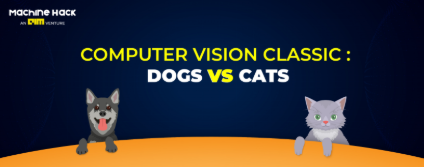

In [4]:
import pandas as pd 
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tqdm
from tqdm import tqdm_notebook
from matplotlib.patches import Rectangle
import seaborn as sns
!pip install pydicom
import pydicom as dcm
%matplotlib inline 
IS_LOCAL = False
import os
if(IS_LOCAL):
    PATH="C:/Users/Surya-Rekha/Downloads"
else:
    PATH="C:/Users/Surya-Rekha/Downloads/Data/Data"
print(os.listdir(PATH))

['.DS_Store', 'Sample_Submission.csv', 'Test', 'Train', 'Train.csv']


In [6]:
from warnings import filterwarnings
filterwarnings('ignore')

In [5]:
train_df = pd.read_csv('C:/Users/Surya-Rekha/Downloads/Data/Data/Train.csv')
train_df.head()

,File_Name,Category
0,10846.jpg,1
1,2360.jpg,1
2,17531.jpg,0
3,13254.jpg,1
4,15554.jpg,0


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
train_gen = train_datagen.flow_from_directory(
        'C:/Users/Surya-Rekha/Downloads/Data/Data/Train',  # this is the target directory
        target_size=(224, 224),  # all images will be resized to 224x224
        batch_size=16,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

Found 9471 images belonging to 2 classes.


In [9]:
test_gen = test_datagen.flow_from_directory(
        'C:/Users/Surya-Rekha/Downloads/Data/Data/Test',
        target_size=(224, 224),
        batch_size=16,
        class_mode='binary')

Found 4059 images belonging to 2 classes.


In [10]:
img_width = 224
img_height = 224
IMAGE_SIZE=224
kernel =3
num_of_classes =2
BATCH_SIZE = 16
EPOCHS = 4
SHUFFLE_BUFFER_SIZE=1000
input_shape = (img_width, img_height, kernel)

In [11]:
# Building the VGG16 Transfer model
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.applications import VGG16
from keras.models import Model
# Initialising the CNN
pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
    
for layer in pre_trained_model.layers[:15]:
    layer.trainable = False

for layer in pre_trained_model.layers[15:]:
    layer.trainable = True
    
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
    
# Flatten the output layer to 1 dimension
x = GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()

Using TensorFlow backend.


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [12]:
from sklearn.model_selection import train_test_split
train_df, validate_df = train_test_split(train_df, test_size=0.1)
train_df = train_df.reset_index()
validate_df = validate_df.reset_index()

# validate_df = validate_df.sample(n=100).reset_index() # use for fast testing code purpose
# train_df = train_df.sample(n=1800).reset_index() # use for fast testing code purpose

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

In [10]:
# fine-tune the model
history = model.fit_generator(
    train_gen,
    epochs=EPOCHS,
    steps_per_epoch=total_train//BATCH_SIZE)

Epoch 1/4


KeyboardInterrupt: ignored

In [13]:
model.evaluate(test_gen, verbose=1)

254/254 [==============================] - 2062s 8s/step


[0.04696550592780113, 0.9544222950935364]

In [15]:
model.save_weights('C:/Users/Surya-Rekha/Downloads/vgg16_95acc_catsvdogs.h5')
print("Saved model weights to disk")

Saved model weights to disk


In [13]:
model.load_weights('C:/Users/Surya-Rekha/Downloads/vgg16_95acc_catsvdogs.h5')

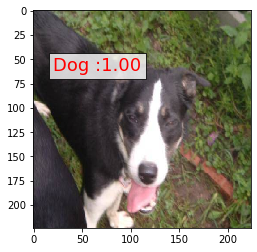

In [14]:
#Prediction of image
%matplotlib inline
import tensorflow
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
img1 = image.load_img('C:/Users/Surya-Rekha/Downloads/Data/Data/Test/Dogs/556.jpg', target_size=(224, 224))
img = image.img_to_array(img1)
img = img/255
# create a batch of size 1 [N,H,W,C]
img = np.expand_dims(img, axis=0)
prediction = model.predict(img, batch_size=None,steps=1) #gives all class prob.
if(prediction[:,:]>0.5):
    value ='Dog :%1.2f'%(prediction[0,0])
    plt.text(20, 62,value,color='red',fontsize=18,bbox=dict(facecolor='white',alpha=0.8))
else:
    value ='Cat :%1.2f'%(1.0-prediction[0,0])
    plt.text(20, 62,value,color='red',fontsize=18,bbox=dict(facecolor='white',alpha=0.8))

plt.imshow(img1)
plt.show()

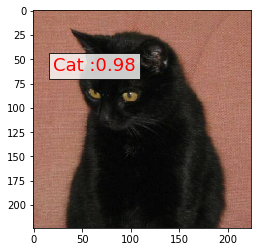

In [15]:
#Prediction of image
%matplotlib inline
import tensorflow
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
img1 = image.load_img('C:/Users/Surya-Rekha/Downloads/Data/Data/Test/Cats/10011.jpg', target_size=(224, 224))
img = image.img_to_array(img1)
img = img/255
# create a batch of size 1 [N,H,W,C]
img = np.expand_dims(img, axis=0)
prediction = model.predict(img, batch_size=None,steps=1) #gives all class prob.
if(prediction[:,:]>0.5):
    value ='Dog :%1.2f'%(prediction[0,0])
    plt.text(20, 62,value,color='red',fontsize=18,bbox=dict(facecolor='white',alpha=0.8))
else:
    value ='Cat :%1.2f'%(1.0-prediction[0,0])
    plt.text(20, 62,value,color='red',fontsize=18,bbox=dict(facecolor='white',alpha=0.8))

plt.imshow(img1)
plt.show()

In [17]:
submit_df = pd.DataFrame({
    'File_Name': test_gen.filenames
})

In [19]:
predict = model.predict(test_gen)
#threshold = 0.5
submit_df['Category'] = predict
submit_df.head()

,File_Name,Category
0,Cats\10008.jpg,0.000247
1,Cats\10009.jpg,0.996031
2,Cats\10011.jpg,0.000003
3,Cats\10012.jpg,0.000063
4,Cats\10013.jpg,0.999999


In [20]:
predicted = [int(round(p[0])) for p in predict]

In [21]:
submission_df = pd.DataFrame({
    'File_Name': test_gen.filenames
})
submission_df['Category'] = predicted
submission_df.head()

,File_Name,Category
0,Cats\10008.jpg,0
1,Cats\10009.jpg,1
2,Cats\10011.jpg,0
3,Cats\10012.jpg,0
4,Cats\10013.jpg,1


In [22]:
submission_df.to_csv('C:/Users/Surya-Rekha/Downloads/VGG16_submission.csv', index=False)